In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *


In [2]:
spark = SparkSession \
    .builder \
    .appName("Regresion lineal en Spark usando pipelines") \
    .getOrCreate()

In [3]:
%%time
table = spark.read.option("header", True).csv("gs://big-data-up/all_data.csv")

CPU times: user 5.4 ms, sys: 3.31 ms, total: 8.71 ms
Wall time: 8.59 s


In [4]:
table.createOrReplaceTempView("quien")

In [5]:
table.show(5)

+--------------------+--------------------+--------+----------------+----------------+------+--------------------+------------------+----------+--------------------+--------------------+----------------+--------------------+--------+----------+
|            producto|        presentacion|   marca|       categoria|        catalogo|precio|       fechaRegistro|   cadenaComercial|      giro|     nombreComercial|           direccion|          estado|           municipio| latitud|  longitud|
+--------------------+--------------------+--------+----------------+----------------+------+--------------------+------------------+----------+--------------------+--------------------+----------------+--------------------+--------+----------+
|CUADERNO FORMA IT...|96 HOJAS PASTA DU...|ESTRELLA|MATERIAL ESCOLAR|UTILES ESCOLARES|  25.9|2011-05-18 00:00:...|ABASTECEDORA LUMEN|PAPELERIAS|ABASTECEDORA LUME...|CANNES No. 6 ESQ....|DISTRITO FEDERAL|TLALPAN          ...|19.29699|-99.125417|
|            CRAYONE

In [6]:
table.printSchema()

root
 |-- producto: string (nullable = true)
 |-- presentacion: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- catalogo: string (nullable = true)
 |-- precio: string (nullable = true)
 |-- fechaRegistro: string (nullable = true)
 |-- cadenaComercial: string (nullable = true)
 |-- giro: string (nullable = true)
 |-- nombreComercial: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)



In [7]:
#remover los datos que traen headers repetidos
quien_clean = spark.sql(" select * from quien where precio != 'precio' ")
quien_clean.createOrReplaceTempView("quien")

In [8]:
#predicción de utiles escolares a partir de estado, municipio y cadenaComecial
df_utiles = spark.sql("""
                        Select estado, municipio, cadenaComercial
                      ,cast(precio as float) from quien 
                      where categoria = 'MATERIAL ESCOLAR' 
                      and precio is not null 
                      and estado is not null
                      and municipio is not null
                      and cadenaComercial is not null
                      """)
df_utiles.show()

+----------------+--------------------+------------------+------+
|          estado|           municipio|   cadenaComercial|precio|
+----------------+--------------------+------------------+------+
|DISTRITO FEDERAL|TLALPAN          ...|ABASTECEDORA LUMEN|  25.9|
|DISTRITO FEDERAL|TLALPAN          ...|ABASTECEDORA LUMEN|  27.5|
|DISTRITO FEDERAL|TLALPAN          ...|ABASTECEDORA LUMEN|  13.9|
|DISTRITO FEDERAL|TLALPAN          ...|ABASTECEDORA LUMEN|  46.9|
|DISTRITO FEDERAL|TLALPAN          ...|ABASTECEDORA LUMEN| 115.0|
|DISTRITO FEDERAL|TLALPAN          ...|ABASTECEDORA LUMEN|  32.5|
|DISTRITO FEDERAL|TLALPAN          ...|ABASTECEDORA LUMEN|   9.0|
|DISTRITO FEDERAL|TLALPAN          ...|ABASTECEDORA LUMEN|  95.9|
|DISTRITO FEDERAL|TLALPAN          ...|ABASTECEDORA LUMEN|  23.2|
|DISTRITO FEDERAL|IZTAPALAPA       ...|    BODEGA AURRERA|  15.0|
|DISTRITO FEDERAL|IZTAPALAPA       ...|    BODEGA AURRERA|  15.0|
|DISTRITO FEDERAL|IZTAPALAPA       ...|    BODEGA AURRERA|  12.9|
|DISTRITO 

In [9]:
df_utiles.printSchema()

root
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- cadenaComercial: string (nullable = true)
 |-- precio: float (nullable = true)



In [10]:
#Regresión lineal
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

In [11]:
str_encoder = StringIndexer(inputCols = ['estado', 'municipio', 'cadenaComercial'], outputCols = ['estado_1', 'municipio_1', 'cadenaComercial_1'])
one_hot_encoder = OneHotEncoder(inputCols = ['estado_1', 'municipio_1', 'cadenaComercial_1'], outputCols = ["estado_2", "municipio_2", "cadenaComercial_2"])
assembler_encoder = VectorAssembler(inputCols = ['estado_2', 'municipio_2', 'cadenaComercial_2'], outputCol = 'features')
lr = LinearRegression(featuresCol = 'features', labelCol = 'precio')
pipeline = Pipeline(stages=[str_encoder, one_hot_encoder, assembler_encoder, lr])



In [12]:
#train test split
splts = df_utiles.randomSplit([0.8, 0.2])
train_df = splts[0]
test_df = splts[1]

In [13]:
model = pipeline.fit(train_df)

22/04/18 20:13:16 WARN org.apache.spark.ml.util.Instrumentation: [00686b71] regParam is zero, which might cause numerical instability and overfitting.
22/04/18 20:15:03 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/18 20:15:03 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/04/18 20:15:04 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/04/18 20:15:04 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
22/04/18 20:15:04 WARN org.apache.spark.ml.util.Instrumentation: [00686b71] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [14]:
#que tiene model?
model.stages

[StringIndexerModel: uid=StringIndexer_1126282d9241, handleInvalid=error, numInputCols=3, numOutputCols=3,
 OneHotEncoderModel: uid=OneHotEncoder_2230ff0a6b95, dropLast=true, handleInvalid=error, numInputCols=3, numOutputCols=3,
 VectorAssembler_c4f9629a28a4,
 LinearRegressionModel: uid=LinearRegression_845eb291b174, numFeatures=524]

In [15]:
model.stages[-1].coefficients

DenseVector([0.308, -0.0892, -0.6326, 0.4854, 0.1071, -0.673, -0.5342, -0.9198, -0.4028, -0.5512, -1.7021, -0.3111, 0.7083, -0.0119, 1.0823, 0.4575, 2.2148, -0.6637, 0.5019, 1.3034, -0.5189, 1.6601, 0.8588, 0.9514, -0.1149, 1.1673, 2.5292, 1.7609, 0.3185, -0.4688, 0.9965, 0.1108, -1.0391, -1.9591, -1.4869, -1.4796, -2.0076, -1.6902, -1.6119, -1.913, -0.4107, -0.1177, -0.1552, -1.3856, -1.9058, -0.1026, -0.2734, 0.2245, 4.9303, 4.5295, -1.9129, -2.8878, -3.6446, -3.6282, -2.4085, -3.2068, 2.2279, -1.3806, -1.0141, -0.8135, -1.4758, 4.6436, 4.9453, 4.9695, 5.5405, -2.8833, 1.2787, 0.2124, -4.3472, 4.2706, -0.272, 3.0652, -1.8639, 4.8422, 2.3187, -0.318, 3.6893, 0.9559, 4.382, 0.416, 2.4579, -0.4732, 5.9618, 4.4431, 2.6586, 2.9867, 5.5003, 3.7453, 1.1459, 3.7304, -1.629, -2.3307, -2.1841, -0.949, 3.6799, -6.8387, 4.5558, 2.8677, 1.782, -7.4283, -16.0115, -1.6049, 5.8161, 5.688, 2.5618, 1.2133, -5.9286, 1.7651, 4.4718, -0.4846, 6.9818, 2.6915, -3.1837, 1.7721, 2.73, -0.6097, -1.929, 3.7982

In [16]:
model.stages[-1].intercept

45.807510159526096

In [17]:
summary = model.stages[-1].summary
print("RMSE {}".format(summary.rootMeanSquaredError))

RMSE 38.08372344847804


In [18]:
prediction = model.transform(test_df)
prediction

DataFrame[estado: string, municipio: string, cadenaComercial: string, precio: float, estado_1: double, municipio_1: double, cadenaComercial_1: double, estado_2: vector, municipio_2: vector, cadenaComercial_2: vector, features: vector, prediction: double]

In [19]:
selected = prediction.select("precio", "prediction").collect()
counter = 0
limit = 10 #solo ver las primeras 10
for row in selected:
    precio, pred = row
    print("precio: {}, predicción {}".format(precio, pred))
    counter += 1
    if counter > limit:
        break
    

precio: 5.900000095367432, predicción 36.28824265765283
precio: 7.0, predicción 36.28824265765283
precio: 7.5, predicción 36.28824265765283
precio: 8.5, predicción 36.28824265765283
precio: 13.899999618530273, predicción 36.28824265765283
precio: 18.5, predicción 36.28824265765283
precio: 20.899999618530273, predicción 36.28824265765283
precio: 22.5, predicción 36.28824265765283
precio: 26.049999237060547, predicción 36.28824265765283
precio: 26.899999618530273, predicción 36.28824265765283
precio: 29.899999618530273, predicción 36.28824265765283


In [20]:
prediction = prediction.withColumn("diff_quad", (precio - prediction["prediction"])**2)
prediction

DataFrame[estado: string, municipio: string, cadenaComercial: string, precio: float, estado_1: double, municipio_1: double, cadenaComercial_1: double, estado_2: vector, municipio_2: vector, cadenaComercial_2: vector, features: vector, prediction: double, diff_quad: double]

In [21]:
import pyspark.sql.functions as F     
suma = prediction.agg(F.sum("diff_quad")).collect()

In [22]:
n = test_df.count()

In [23]:
n

525227

In [24]:
suma

[Row(sum(diff_quad)=743415920.0954193)]

In [25]:
(suma[0][0] / n) ** (1/2)
#lo que significa que el modelo es feo pero no está sobreajustado

37.62204571881089

In [80]:
residuals = prediction.withColumn("resds", precio - prediction["prediction"]).select(["precio", "prediction", "resds"])

In [81]:
res = residuals.toPandas()

In [38]:
from matplotlib import pyplot as plt
res.shape

(525227, 1)

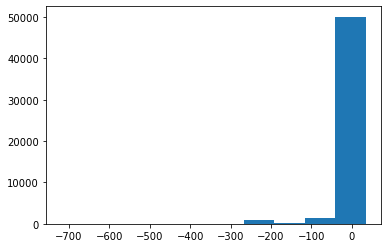

In [82]:
from scipy import stats
plt.hist(res["resds"].sample(res.shape[0]//10))
plt.show()

In [83]:
#si p value > 0.05, no se rechaza H0 y entonces se distribuyen normalmente
stats.jarque_bera(res["resds"].sample(res.shape[0]//5))

Jarque_beraResult(statistic=9248402.340208434, pvalue=0.0)

In [89]:
from sklearn.metrics import r2_score
r2 = r2_score(res["precio"], res["prediction"])
r2
#pero si es un mal modelo, estaríamos esperano uno entre 0.7 y 0.9 (cerca de 0.9 ya es sospechoso)

0.449899182652719

In [90]:
spark.stop()